<a href="https://colab.research.google.com/github/andreagurioli1995/IoT-Air-Quality-Monitoring-System/blob/stable/forecasting/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [ ]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

# Data retrival from influx

In [ ]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
token = 'XcmfhaTm0yJzZhnThQBO26FZvYgtP0QJAocHVUucCoXcr9Vmymk69vOrJJ42_G03Y3h35KG0iapZM4dSE49AwQ=='
#bucket = $my-bucket
org = 'iot-org'
client = InfluxDBClient(url="http://localhost:8086", token=token, org=org)
query_api = client.query_api()
write_api = client.write_api(write_options=SYNCHRONOUS)

In [ ]:
query = 'from(bucket:"temperature")' \
        ' |> range(start:2007-12-10T15:00:00Z, stop:2016-01-20T15:00:00Z)'\
        ' |> filter(fn: (r) => r._measurement == "views")' \
        ' |> filter(fn: (r) => r._field == "y")'

In [ ]:
result = client.query_api().query(org=org, query=query)

-Exploiting the query results in order to obtain a dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Implementation Temperature Predictor

In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/Forecasting/temp.csv"
df = pd.read_csv(dataset_path)
df.head()

,409151bfa0cc,409151bfa0cc.1
0,2022-06-05 23:02:52,28.2
1,2022-06-05 23:02:54,28.2
2,2022-06-05 23:02:57,28.1
3,2022-06-05 23:02:59,28.2
4,2022-06-05 23:03:02,28.2


In [ ]:
df.head()

,time,y
0,2022-06-05 23:02:52,28.2
1,2022-06-05 23:02:54,28.2
2,2022-06-05 23:02:57,28.1
3,2022-06-05 23:02:59,28.2
4,2022-06-05 23:03:02,28.2


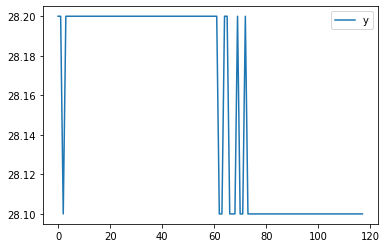

In [ ]:
#evolution over time of our data
plot_cols = ['y']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)



In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y,118.0,28.155085,0.049953,28.1,28.1,28.2,28.2,28.2


In [ ]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.60)
train = df['y'] [:splitPoint]
test = df ['y'] [splitPoint:]

In [ ]:
 # Check whether the time-series is stationary through the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.539168
p-value: 0.884144


In [ ]:
train_new = train.diff().dropna()
result = adfuller(train_new)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.644909
p-value: 0.004958


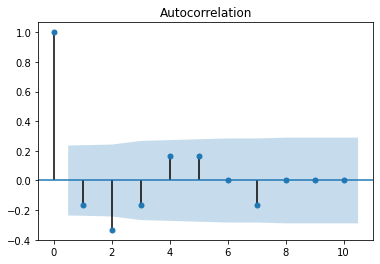

In [ ]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train_new, lags=10)
plt.show()

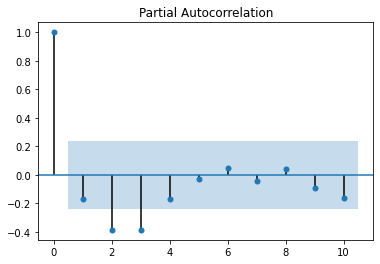

In [ ]:
fig = tsaplots.plot_pacf(train_new, lags=10)
plt.show()

In [ ]:
#Step 6; Apply ARIMA model
from statsmodels.tsa.arima_model import ARIMA
history = [x for x in train]
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(0,0,1))
  model_fit = model. fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

70     28.1
71     28.1
72     28.2
73     28.1
74     28.1
75     28.1
76     28.1
77     28.1
78     28.1
79     28.1
80     28.1
81     28.1
82     28.1
83     28.1
84     28.1
85     28.1
86     28.1
87     28.1
88     28.1
89     28.1
90     28.1
91     28.1
92     28.1
93     28.1
94     28.1
95     28.1
96     28.1
97     28.1
98     28.1
99     28.1
100    28.1
101    28.1
102    28.1
103    28.1
104    28.1
105    28.1
106    28.1
107    28.1
108    28.1
109    28.1
110    28.1
111    28.1
112    28.1
113    28.1
114    28.1
115    28.1
116    28.1
117    28.1
Name: y, dtype: float64
predicted=28.167454, expected=28.100000
predicted=28.132606, expected=28.100000
predicted=28.122595, expected=28.200000
predicted=28.148761, expected=28.100000
predicted=28.133078, expected=28.100000
predicted=28.123689, expected=28.100000
predicted=28.116686, expected=28.100000
predicted=28.111365, expected=28.100000
predicted=28.107364, expected=28.100000
predicted=28.104386, expected=28.100000


Test RMSE: 0.019


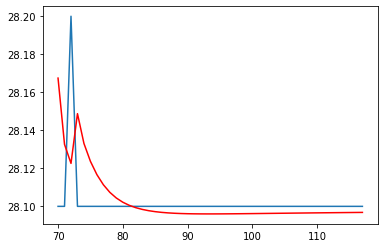

In [ ]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show()

## Implementation Humidity Predictor

In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/Forecasting/hum.csv"
df = pd.read_csv(dataset_path)
df.head()

,409151bfa0cc,409151bfa0cc.1
0,2022-06-05 23:03:12,49.9
1,2022-06-05 23:03:15,49.9
2,2022-06-05 23:03:17,49.9
3,2022-06-05 23:03:20,49.8
4,2022-06-05 23:03:22,49.8


In [ ]:
df = df.rename(columns={"409151bfa0cc" : 'time', "409151bfa0cc.1" : 'y'})
df.head()

,time,y
0,2022-06-05 23:03:12,49.9
1,2022-06-05 23:03:15,49.9
2,2022-06-05 23:03:17,49.9
3,2022-06-05 23:03:20,49.8
4,2022-06-05 23:03:22,49.8


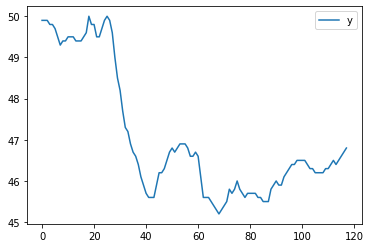

In [ ]:
#evolution over time of our data
plot_cols = ['y']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y,118.0,47.049153,1.572344,45.2,45.825,46.45,48.425,50.0


In [ ]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.60)
train = df['y'] [:splitPoint]
test = df ['y'] [splitPoint:]

In [ ]:
 # Check whether the time-series is stationary through the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.015842
p-value: 0.747443


In [ ]:
train_new = train.diff().dropna()
result = adfuller(train_new)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.107289
p-value: 0.000942


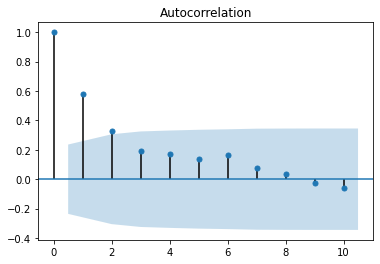

In [ ]:
fig = tsaplots.plot_acf(train_new, lags=10)
plt.show()

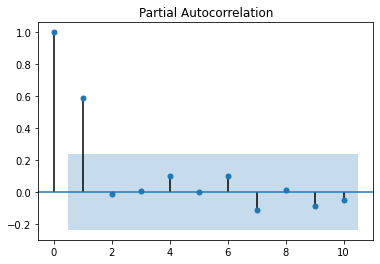

In [ ]:
fig = tsaplots.plot_pacf(train_new, lags=10)
plt.show()

In [ ]:
history = [x for x in train]
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(1,1,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

70     45.4
71     45.5
72     45.8
73     45.7
74     45.8
75     46.0
76     45.8
77     45.7
78     45.6
79     45.7
80     45.7
81     45.7
82     45.7
83     45.6
84     45.6
85     45.5
86     45.5
87     45.5
88     45.8
89     45.9
90     46.0
91     45.9
92     45.9
93     46.1
94     46.2
95     46.3
96     46.4
97     46.4
98     46.5
99     46.5
100    46.5
101    46.5
102    46.4
103    46.3
104    46.3
105    46.2
106    46.2
107    46.2
108    46.2
109    46.3
110    46.3
111    46.4
112    46.5
113    46.4
114    46.5
115    46.6
116    46.7
117    46.8
Name: y, dtype: float64
predicted=45.334564, expected=45.400000
predicted=45.431918, expected=45.500000
predicted=45.533882, expected=45.800000
predicted=45.962611, expected=45.700000
predicted=45.616654, expected=45.800000
predicted=45.831229, expected=46.000000
predicted=46.096168, expected=45.800000
predicted=45.672093, expected=45.700000
predicted=45.617550, expected=45.600000
predicted=45.519439, expected=45.700000


Test RMSE: 0.118


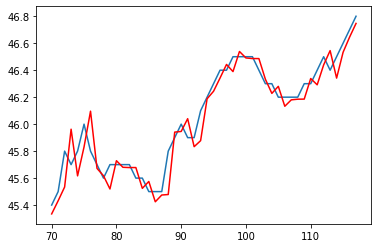

In [ ]:
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd.DataFrame(predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show()

## Implement Gas Predictor

In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/Forecasting/gas.csv"
df = pd.read_csv(dataset_path)

In [ ]:
df.head()

,Time,y
0,2022-06-05 21:07:11,4095
1,2022-06-05 21:07:13,4095
2,2022-06-05 21:07:16,4095
3,2022-06-05 21:07:18,4095
4,2022-06-05 21:07:21,4095


In [ ]:
df['y'].size

4288

In [ ]:
df['y'][0:4288] = 4095

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


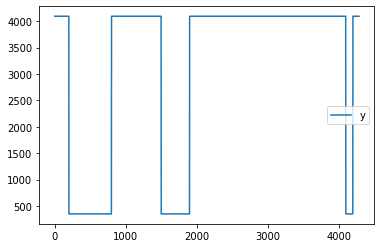

In [ ]:
#evolution over time of our data
plot_cols = ['y']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

In [ ]:
df['y'][3000:4000] = [4095 for i in range(0,1000)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y,4288.0,3134.295709,1635.698257,350.0,350.0,4095.0,4095.0,4095.0


In [ ]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.50)
train = df['y'] [:splitPoint]
test = df ['y'] [splitPoint:]

Check for stationarity 

In [ ]:
 # Check whether the time-series is stationary through the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.005413
p-value: 0.284205


In [ ]:
train_new = train.diff().dropna()
result = adfuller(train_new)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -46.260134
p-value: 0.000000


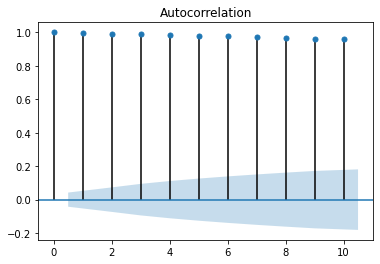

In [ ]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train, lags=10)
plt.show()

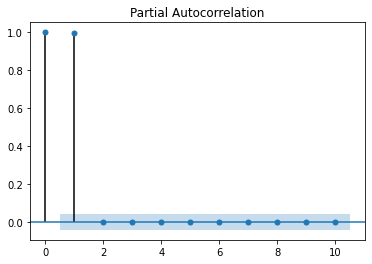

In [ ]:
fig = tsaplots.plot_pacf(train, lags=10)
plt.show()

In [ ]:
# Apply ARIMA model
from statsmodels.tsa.arima_model import ARIMA
history = list(np.array([x for x in train_new]).astype('float64'))
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(1,1,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

2144    4095
2145    4095
2146    4095
2147    4095
2148    4095
        ... 
4283    4095
4284    4095
4285    4095
4286    4095
4287    4095
Name: y, Length: 2144, dtype: int64
predicted=0.000000, expected=4095.000000
predicted=5463.295310, expected=4095.000000
predicted=6889.720720, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4094.999999, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4095.000000, expected=4095.000000
predicted=4094.999999, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000004, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000001, expected=4095.000000
predicted=4095.000002, expected=

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4094.999999, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4094.999999, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4094.999998, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4094.999999, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000001, expected=4095.000000
predicted=4095.000001, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4094.999999, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000001, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000001, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=4095.000000
predicted=4095.000000, expected=

Test RMSE: 180.939


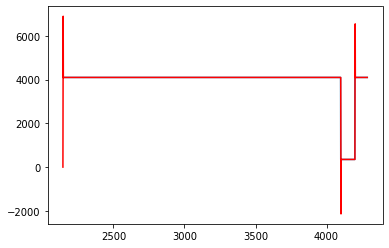

In [ ]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show()

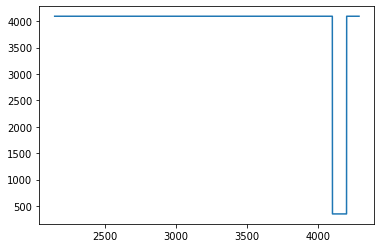

In [ ]:
plt.plot(test)


In [ ]:
import pickle
pickle.dump(model_fit, open('gas-model', 'wb'))